<a href="https://colab.research.google.com/github/kaczquszka/kwiatuszki/blob/main/model_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from datasets import Dataset, DatasetDict
dataset = pd.read_csv("answers_tab.csv", sep ="\t")

In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer

In [11]:
id2label = {0:'negative', 1:'neutral', 2:'positive'}
label2id = {id2label[items]: items for items in id2label}

model_checkpoint = 'distilbert-base-uncased'
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels = 3, id2label = id2label, label2id=label2id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
dataset = Dataset.from_dict({'text': dataset.iloc[:,0], 'label':dataset.iloc[:,-1]})
dataset = DatasetDict({'train': dataset})

In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1632
    })
})

In [14]:
from collections import Counter

Counter(dataset['train']["label"])

Counter({'positive': 638, 'negative': 508, 'neutral': 486})

In [15]:
def mapping(example):
  example['label'] = label2id[example['label']]
  return example

In [16]:
dataset = dataset['train'].map(mapping)

Map:   0%|          | 0/1632 [00:00<?, ? examples/s]

In [17]:
Counter(dataset['label'])

Counter({2: 638, 0: 508, 1: 486})

In [18]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 1632
})

In [19]:
from sklearn.model_selection import train_test_split
dataset = dataset.train_test_split( test_size = 0.2, seed = 67)
#20% do testu

In [20]:
dataset
#https://www.learnhuggingface.com/notebooks/hugging_face_text_classification_tutorial?

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1305
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 327
    })
})

In [21]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [22]:
tokenizer('no i dont like it')
tokenizer.model_max_length = 100 #tylko 100 bo mamy krótkie zdania, być może trzeba będzie rozważyć wydłużenie
tokenizer.convert_ids_to_tokens(tokenizer('Marta').input_ids)

['[CLS]', 'marta', '[SEP]']

In [23]:
def tokenize_datset(example):
  return tokenizer(example['text'], truncation=True, padding=True)

In [24]:
tokenized_dataset = dataset.map(tokenize_datset, batched =True, batch_size=1000)

Map:   0%|          | 0/1305 [00:00<?, ? examples/s]

Map:   0%|          | 0/327 [00:00<?, ? examples/s]

In [25]:
tokenized_dataset.keys()

dict_keys(['train', 'test'])

In [27]:
import evaluate
import numpy as np
accuracy = evaluate.load('accuracy')

In [28]:
def compute_accuracy(predictions_and_labels: tuple[np.array, np.array]):
  predictions, labels = predictions_and_labels
  if (len(predictions.shape)>=2):
    predictions = np.argmax(predictions, axis=1)
  return accuracy.compute(predictions=predictions, references=labels)

In [29]:
# Create example list of predictions and labels
example_predictions_all_correct = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
example_predictions_one_wrong = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
example_labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Test the function
print(f"Accuracy when all predictions are correct: {compute_accuracy((example_predictions_all_correct, example_labels))}")
print(f"Accuracy when one prediction is wrong: {compute_accuracy((example_predictions_one_wrong, example_labels))}")

Accuracy when all predictions are correct: {'accuracy': 1.0}
Accuracy when one prediction is wrong: {'accuracy': 0.9}


In [ ]:
model

In [30]:
learn_rate = 0.00001
epochs = 10
batch_train = 20
batch_eval = 20

In [31]:
from pathlib import Path
m_dir = Path("models")
m_dir.mkdir(exist_ok = True)
model_name = ('fine-tuned-on-1000-answers-distilbert-base-uncased')

model_directory = Path(m_dir,model_name)
model_directory

PosixPath('models/fine-tuned-on-1000-answers-distilbert-base-uncased')

In [32]:
training_args = TrainingArguments(
    output_dir = model_directory,
    learning_rate = learn_rate,
    per_device_train_batch_size = batch_train,
    per_device_eval_batch_size	= batch_eval,
    num_train_epochs = epochs,
    eval_strategy = 'epoch',
    seed = 67,
    save_strategy ='epoch',
    logging_strategy = 'epoch',
    report_to = 'none'
)

In [33]:
trainer = Trainer(
    model = model,
    args=training_args,
    train_dataset = tokenized_dataset['train'],
    eval_dataset = tokenized_dataset['test'],
    tokenizer = tokenizer,
    compute_metrics = compute_accuracy)

/tmp/ipython-input-2655332214.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [34]:
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.002500,0.809181,0.669725
2,0.644800,0.584767,0.752294
3,0.461700,0.487959,0.816514
4,0.344500,0.450551,0.822630
5,0.266300,0.430668,0.828746
6,0.201000,0.428895,0.850153
7,0.163400,0.430214,0.840979
8,0.140600,0.440968,0.834862
9,0.121900,0.436529,0.853211
10,0.108700,0.436663,0.853211


In [35]:
trainer.save_model(model_directory)


In [36]:
log_history = trainer.state.log_history[:-1]

In [37]:
log_history[:4]

[{'loss': 1.0025,
  'grad_norm': 5.163207530975342,
  'learning_rate': 9.015151515151516e-06,
  'epoch': 1.0,
  'step': 66},
 {'eval_loss': 0.8091810345649719,
  'eval_accuracy': 0.6697247706422018,
  'eval_runtime': 0.3194,
  'eval_samples_per_second': 1023.904,
  'eval_steps_per_second': 53.231,
  'epoch': 1.0,
  'step': 66},
 {'loss': 0.6448,
  'grad_norm': 3.253797769546509,
  'learning_rate': 8.015151515151515e-06,
  'epoch': 2.0,
  'step': 132},
 {'eval_loss': 0.5847665071487427,
  'eval_accuracy': 0.7522935779816514,
  'eval_runtime': 0.4113,
  'eval_samples_per_second': 795.08,
  'eval_steps_per_second': 41.334,
  'epoch': 2.0,
  'step': 132}]

In [38]:
loss_history=[]
eval_history=[]

for item in log_history:
  key = item.keys()
  if any('eval_loss' in x for x in key):
    eval_history.append(item)
  else:
    loss_history.append(item)

In [39]:
loss_df = pd.DataFrame(loss_history)
eval_df = pd.DataFrame(eval_history)

In [40]:
loss_df

,loss,grad_norm,learning_rate,epoch,step
0,1.0025,5.163208,9.015152e-06,1.0,66
1,0.6448,3.253798,8.015152e-06,2.0,132
2,0.4617,9.856058,7.015152e-06,3.0,198
3,0.3445,6.089380,6.015152e-06,4.0,264
4,0.2663,3.457302,5.015152e-06,5.0,330
5,0.2010,2.436952,4.015152e-06,6.0,396
6,0.1634,1.247485,3.015152e-06,7.0,462
7,0.1406,0.549309,2.015152e-06,8.0,528
8,0.1219,1.773373,1.015152e-06,9.0,594
9,0.1087,25.558977,1.515152e-08,10.0,660


In [41]:
eval_df

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.809181,0.669725,0.3194,1023.904,53.231,1.0,66
1,0.584767,0.752294,0.4113,795.080,41.334,2.0,132
2,0.487959,0.816514,0.3766,868.325,45.142,3.0,198
3,0.450551,0.822630,0.3665,892.145,46.381,4.0,264
4,0.430668,0.828746,0.3848,849.714,44.175,5.0,330
5,0.428895,0.850153,0.3351,975.765,50.728,6.0,396
6,0.430214,0.840979,0.7669,426.370,22.166,7.0,462
7,0.440968,0.834862,0.4242,770.806,40.072,8.0,528
8,0.436529,0.853211,0.3371,969.928,50.424,9.0,594
9,0.436663,0.853211,0.4974,657.434,34.179,10.0,660


In [42]:
best_epoch_acc = eval_df['eval_accuracy'].idxmax()
smallest_val_loss = eval_df['eval_loss'].idxmin()
smallest_val_loss


5

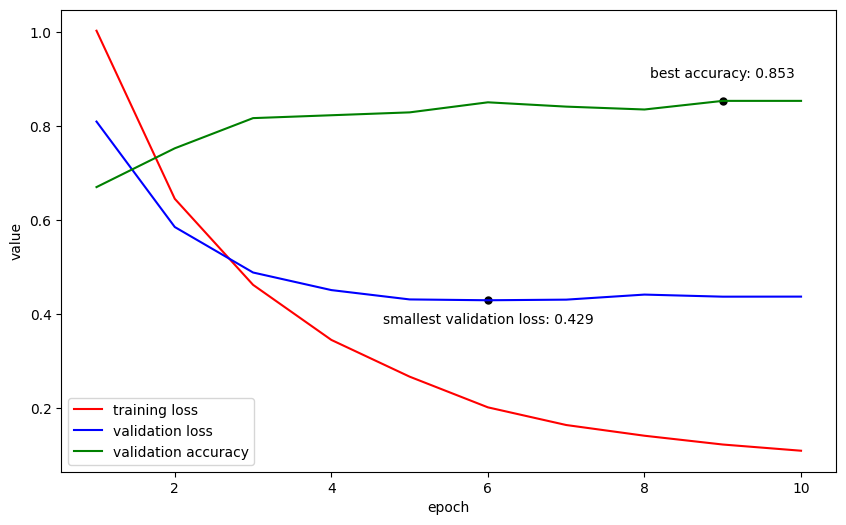

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(loss_df['epoch'], loss_df['loss'], color='red', label='training loss')
plt.plot(eval_df['epoch'], eval_df['eval_loss'], color='blue',label='validation loss')
plt.plot(eval_df['epoch'], eval_df['eval_accuracy'], color='green', label='validation accuracy')
plt.scatter(best_epoch_acc+1, eval_df.loc[best_epoch_acc]['eval_accuracy'], s=25, color='black')
plt.text(best_epoch_acc+1, eval_df.loc[best_epoch_acc]['eval_accuracy']+ 0.05, f"best accuracy: {(eval_df.loc[best_epoch_acc]['eval_accuracy']):.3f}", ha='center')
plt.scatter(smallest_val_loss+1, eval_df.loc[smallest_val_loss]['eval_loss'], s=25, color='black')
plt.text(smallest_val_loss+1, eval_df.loc[smallest_val_loss]['eval_loss']- 0.05, f"smallest validation loss: {(eval_df.loc[smallest_val_loss]['eval_loss']):.3f}", ha='center')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('value')
plt.show()

In [ ]:
checkpoint_path = "/content/models/fine-tuned-on-1000-answers-distilbert-base-uncased/checkpoint-396" #saving 6th epoch
repo_name = "kaczquszka/fine-tuned-on-1000-answers-distilbert-base-uncased"


best_model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

In [45]:
from google.colab import userdata
best_model.push_to_hub(
    repo_id=repo_name,
    commit_message="Uploading model",
    token = userdata.get('hug_token')
)
tokenizer.push_to_hub(
    repo_id=repo_name,
    commit_message="Uploading tokenizer",
    token=userdata.get('hug_token')
)

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...nhj29pr/model.safetensors:   2%|2         | 6.37MB /  268MB            

CommitInfo(commit_url='https://huggingface.co/kaczquszka/fine-tuned-on-1000-answers-distilbert-base-uncased/commit/05ae506af4977aeef007afa2c11ee6b6dd5d74e6', commit_message='Uploading tokenizer', commit_description='', oid='05ae506af4977aeef007afa2c11ee6b6dd5d74e6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/kaczquszka/fine-tuned-on-1000-answers-distilbert-base-uncased', endpoint='https://huggingface.co', repo_type='model', repo_id='kaczquszka/fine-tuned-on-1000-answers-distilbert-base-uncased'), pr_revision=None, pr_num=None)

In [ ]:
predictions_all = trainer.predict(tokenized_dataset["test"])
prediction_values = predictions_all.predictions
prediction_metrics = predictions_all.metrics

In [ ]:
print(tokenized_dataset['test']['text'])

In [ ]:
import torch
predictions= np.array(torch.softmax(torch.tensor(prediction_values), dim=1))
predictions
for row in range(predictions.shape[0]):
    print(tokenized_dataset['test']['text'][row], ", ".join(f"{label}: {predictions[row][id]:.3f}" for id, label in id2label.items()))




In [ ]:
from transformers import pipeline
model_path ='kaczquszka/fine-tuned-on-1000-answers-distilbert-base-uncased'
BATCH_SIZE = 10
classify_sentiment = pipeline(task='text-classification',model = model_path, batch_size = BATCH_SIZE, top_k =3)

In [ ]:
sentences = [
    "I whipped up a fresh batch of code, but it seems to have a syntax error.",
    "We need to marinate these ideas overnight before presenting them to the client.",
    "The new software is definitely a spicy upgrade, taking some time to get used to.",
    "Her social media post was the perfect recipe for a viral sensation.",
    "He served up a rebuttal full of facts, leaving his opponent speechless.",
    "The team needs to simmer down a bit before tackling the next challenge.",
    "The presentation was a delicious blend of humor and information, keeping the audience engaged.",
    "A beautiful array of fake wax foods (shokuhin sampuru) in the front of a Japanese restaurant.",
    "Daniel Bourke is really cool :D",
    "My favoruite food is biltong!"
]

classify_sentiment(sentences)

In [ ]:
testing_token = AutoTokenizer.from_pretrained(model_path)

inputs = testing_token(sentences, return_tensors ='pt', truncation=True, padding=True)
inputs

In [ ]:
testing_model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
testing_model(**inputs)